# Computer Vision with PyTorch 

### Libraries for vision in PyTorch
- `torchvision`: Base library
- `torchvision.datasets`
- `torchvision.models`
- `torchvision.transforms`
- `torchvision.utils.data.Dataset`: Base dataset class
- `torchvision.utils.data.DataLoader`: Create Python iterable over a dataset

In [67]:
# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualising
import matplotlib.pyplot as plt

# For evaluations
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19 # version > 0.19.0
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
# Other miscellaneous libraries
import numpy as np
import collections
from tqdm.auto import tqdm
import pandas as pd

print(torch.__version__)
print(torchvision.__version__)

mlxtend version: 0.21.0
1.12.1+cu102
0.13.1+cu102


In [69]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("already exists, skipping..")
else:
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    request = requests.get(url)
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn

already exists, skipping..


## 1. Getting a dataset

In [3]:
# FashionMNIST
# setup training data
train_data = datasets.FashionMNIST(root="data",
                                   train=True, 
                                   download=True, 
                                   transform=ToTensor(),
                                   target_transform=None)

test_data = datasets.FashionMNIST(root="data",
                                   train=False, 
                                   download=True, 
                                   transform=ToTensor(),
                                   target_transform=None)

### 1.1 Examine data

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
# view the first training example
image, label = train_data[0]
# image, label

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets, torch.unique(train_data.targets)

(tensor([9, 0, 0,  ..., 3, 0, 5]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [9]:
# number of samples in each class
collections.Counter(np.array(train_data.targets))

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

In [10]:
print(f"Image shape: {image.shape} \nImage Label: {label, class_names[label]}")

Image shape: torch.Size([1, 28, 28]) 
Image Label: (9, 'Ankle boot')


### 1.2 Visualise data

Image shape: torch.Size([1, 28, 28])


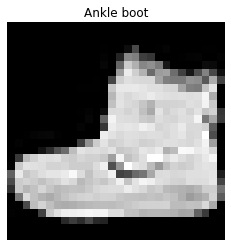

In [11]:
image, label = train_data[0]

print(f"Image shape: {image.shape}")

plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
plt.show()

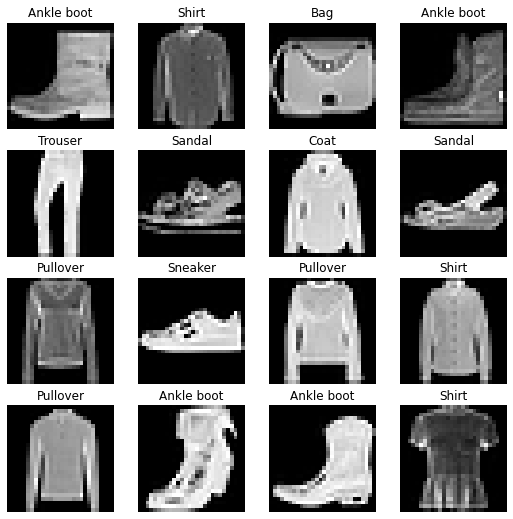

In [12]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [13]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

# 2. Preprare DataLoaders

- Convert data to batches or mini-batches

In [140]:
# Set batch size parameter hyperparameter

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE,
                             shuffle=False) # Don't shuffle test data!

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f5ce789a580>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5ce789a0a0>)

In [15]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f5d82464fd0>, <torch.utils.data.dataloader.DataLoader object at 0x7f5d824640a0>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [16]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label 8 size: torch.Size([])


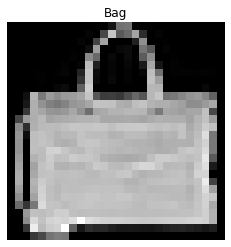

In [17]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label {label} size: {label.shape}")

## 3. Model 0: Build a baseline model

- Best practice to start with a baseline and then improve upon it

### Note: Creating a flatten model

In [18]:
flatten_model = nn.Flatten()

x = train_features_batch[0]
output = flatten_model(x)

print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [19]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, 
                 input_shape: int, 
                 hidden_units:int, 
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten the image first
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units, 
                      out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [20]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28, 
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [21]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1 Setup loss, optimiser and evaluation metrics

1. Loss function - multi class classification, so crossentropy loss
2. evaluation metric - accuracy since classification

In [22]:
# Setup loss function loss and optimiser

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time experiments

In [23]:
from timeit import default_timer as timer

def print_train_time(start: float, 
                     end: float, 
                     device: torch.device=None):
    """
    Prints the time between start time and end time 
    """
    total_time = end - start
    print(f"Train time on {device} is {total_time:.3f} seconds.")
    return total_time

In [24]:
start_time = timer()
end_time = timer()
print_train_time(start_time, end_time)

Train time on None is 0.000 seconds.


3.6736000765813515e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss per batch
3. Loop through testing batches, perform testing steps, calculate the test loss per batch
4. Print out what's happening
5. Time it all 

In [25]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs 
EPOCHS = 1

# Create training and testing loop
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n-----")
    train_loss = 0
    
    # Add a loop to go through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        
        # 1. Forward pass
        y_pred = model_0(X)
        
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += 0 # accumulate train loss
        
        # 3. Optimiser zero grad
        optimiser.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimiser step: NOTE that the updation of parameters happens once per batch
        optimiser.step() 
        
        # Print progress
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
        
    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass 
            test_pred = model_0(X_test)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate acc (accumulatively)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))


        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test loss average per batch
        test_acc /= len(test_dataloader)
        
    # Print progress
    print(f"\nTrain Loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    
# Calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.0000 | Test loss: 0.5102 | Test acc: 82.0387
Train time on cpu is 4.512 seconds.


# 4. Make predictions and get Model 0 results

In [26]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """
    Returns a dictionary containing the reuslts of model predicting on data_loader
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions
            y_pred = model(X)
            
            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                               y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with class
            "model_loss": loss.item(),
            "model_acc": acc}

# calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5100331902503967,
 'model_acc': 82.02875399361022}

## 5. Setup device agnostic-code 

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


## 6. Building Model 1 

In [28]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

### 6.1 Create an instance of model and setup loss and optimiser

In [29]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [30]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

### 6.2 Functionising training and evaluation/testing loops

1. training loop: `train_step()`
2. testing loop: `test_step()`

In [31]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [32]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95690 | Test accuracy: 64.98%

Epoch: 1
---------
Train loss: 0.73779 | Train accuracy: 73.69%
Test loss: 0.72388 | Test accuracy: 74.21%

Epoch: 2
---------
Train loss: 0.66776 | Train accuracy: 76.08%
Test loss: 0.68751 | Test accuracy: 75.64%

Train time on cuda is 17.416 seconds.


In [33]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """
    Returns a dictionary containing the reuslts of model predicting on data_loader
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make data device agnostic
            X, y = X.to(device), y.to(device)
            
            # Make predictions
            y_pred = model(X)
            
            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                               y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with class
            "model_loss": loss.item(),
            "model_acc": acc}

# calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device='cpu')
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5100331902503967,
 'model_acc': 82.02875399361022}

In [34]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

  0%|          | 0/313 [00:00<?, ?it/s]

In [35]:
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6878560781478882,
 'model_acc': 75.62899361022365}

In [36]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5100331902503967,
 'model_acc': 82.02875399361022}

## 7. Model 2: CNN

- Refer: https://poloclub.github.io/cnn-explainer/

In [37]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [38]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # equal to number of colour channels 
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

#### How to calculate the value for in_features to the Linear layer in the classifier?

torch.Size([1, 28, 28])

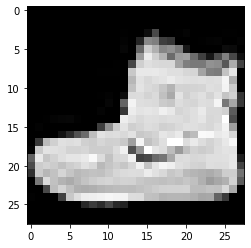

In [39]:
plt.imshow(image.squeeze(), cmap='gray')
image.shape

#### Print out the values of each conv block to calculate the value. In this case, 10 * 7 * 7

In [40]:
model_2(image.unsqueeze(0).to(device))

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [41]:
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 7.1 Inside the `nn.Conv2d()` layer

In [42]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print("shape of batch of images:", images.shape)
print("shape of single image:", test_image.shape)

shape of batch of images: torch.Size([32, 3, 64, 64])
shape of single image: torch.Size([3, 64, 64])


In [43]:
model_2.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
           

In [44]:
torch.manual_seed(42)
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, # number of colour channels 
                       out_channels=10, # no of hidden units
                       kernel_size=(3,3), # filter size 
                       stride=1, # check slides / website animation to understnd 
                       padding=1 # ditto 
                      )

# Pass the data through the test image
test_image_out = conv_layer(test_image)
test_image_out.shape

torch.Size([10, 64, 64])

In [45]:
torch.manual_seed(42)
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, # number of colour channels 
                       out_channels=10, # no of hidden units
                       kernel_size=(3,3), # filter size 
                       stride=1, # check slides / website animation to understnd 
                       padding=0 # ditto 
                      )

# Pass the data through the test image
test_image_out = conv_layer(test_image)
test_image_out.shape

torch.Size([10, 62, 62])

In [46]:
torch.manual_seed(42)
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, # number of colour channels 
                       out_channels=10, # no of hidden units
                       kernel_size=(3,3), # filter size 
                       stride=2, # check slides / website animation to understnd 
                       padding=1 # ditto 
                      )

# Pass the data through the test image
test_image_out = conv_layer(test_image)
test_image_out.shape, test_image.shape

(torch.Size([10, 32, 32]), torch.Size([3, 64, 64]))

### 7.2 Inside the `nn.MaxPool2d()` layer

In [47]:
torch.manual_seed(42)

# Create a maxpool layer 
maxpool_layer = nn.MaxPool2d(kernel_size=(2,2))

# Pass data through conv layer then maxpool layer
test_image_out = conv_layer(test_image)
test_image_final = maxpool_layer(test_image_out)
test_image_final.shape, test_image_out.shape, test_image.shape

(torch.Size([10, 16, 16]), torch.Size([10, 32, 32]), torch.Size([3, 64, 64]))

In [48]:
torch.manual_seed(42)

# Create a maxpool layer 
maxpool_layer = nn.MaxPool2d(kernel_size=(3,3))

# Pass data through conv layer then maxpool layer
test_image_out = conv_layer(test_image)
test_image_final = maxpool_layer(test_image_out)
test_image_final.shape, test_image_out.shape, test_image.shape

(torch.Size([10, 10, 10]), torch.Size([10, 32, 32]), torch.Size([3, 64, 64]))

In [49]:
torch.manual_seed(42)

random_tensor = torch.randn(size=(1, 1, 2, 2)) 

# Create a maxpool layer 
maxpool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through maxpool layer
random_tensor_final = maxpool_layer(random_tensor)
random_tensor_final.shape, random_tensor.shape

(torch.Size([1, 1, 1, 1]), torch.Size([1, 1, 2, 2]))

In [50]:
random_tensor, random_tensor_final

(tensor([[[[0.3367, 0.1288],
           [0.2345, 0.2303]]]]),
 tensor([[[[0.3367]]]]))

### 7.3 Setup the loss function and optimiser

In [51]:
# Setup loss function/eval metrics/optimiser

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### 7.4 Training and Testing `model_2`

In [52]:
torch.manual_seed(42)

# Measure time
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimiser,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59712 | Train accuracy: 78.33%
Test loss: 0.39648 | Test accuracy: 85.88%

Epoch: 1
---------
Train loss: 0.35890 | Train accuracy: 87.08%
Test loss: 0.39017 | Test accuracy: 86.43%

Epoch: 2
---------
Train loss: 0.32243 | Train accuracy: 88.44%
Test loss: 0.34504 | Test accuracy: 87.76%

Train time on cuda is 24.207 seconds.


In [94]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device='cuda')
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3443238437175751,
 'model_acc': 87.77955271565496}

## 8. Compare model results and training time

In [54]:
comapre_results = pd.DataFrame([model_0_results, 
                                model_1_results,
                                model_2_results])

comapre_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.510033,82.028754
1,FashionMNISTModelV1,0.687856,75.628994
2,FashionMNISTModelV2,0.344571,87.759585


In [55]:
# Add training time to results comparison

comapre_results["training_time"] = [total_train_time_model_0, 
                                    total_train_time_model_1,
                                    total_train_time_model_2]

comapre_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.510033,82.028754,4.511950
1,FashionMNISTModelV1,0.687856,75.628994,17.415957
2,FashionMNISTModelV2,0.344571,87.759585,24.206641


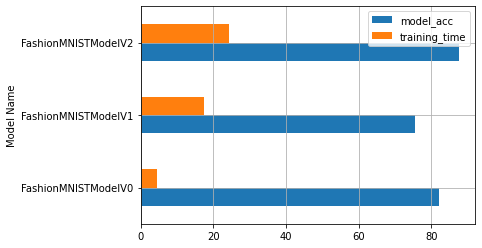

In [82]:
# Visualise the model results
comapre_results.set_index("model_name")[["model_acc", "training_time"]].plot(kind="barh")
# plt.xlabel("Accuracy (%)")
plt.ylabel("Model Name")
plt.grid()
plt.show()

## 9. Make and evaluate random predictions with the best model

In [57]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
    pred_probs=[]
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add dimension and send to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # Forward pass
            pred_logit = model(sample)
            
            # Get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
        # Stack the pred_probs to turn list into a tensor
        return torch.stack(pred_probs)

In [130]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [131]:
# View first sample shape
print(test_samples[0].shape)

torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Trouser')

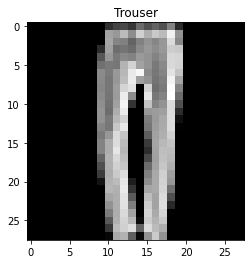

In [132]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [133]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 6, 0, 3, 0, 6, 8, 3, 2])

In [134]:
test_labels

[1, 0, 6, 3, 0, 6, 8, 3, 2]

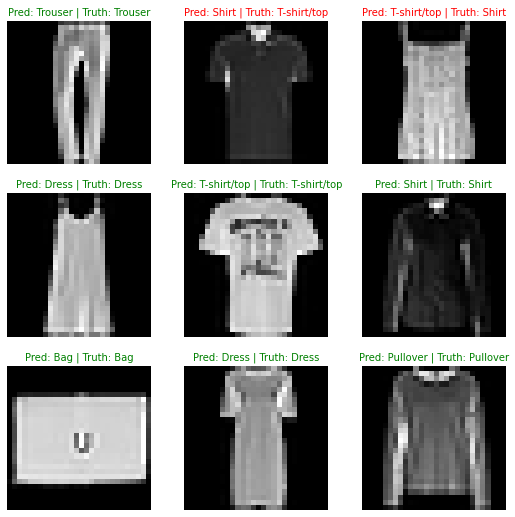

In [135]:
plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
        
    plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

In [141]:
# 1. Make predictions with trained model
torch.manual_seed(42)
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions.."):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        
y_pred_tensor = torch.cat(y_preds)

Making predictions..:   0%|          | 0/313 [00:00<?, ?it/s]

In [143]:
len(y_pred_tensor)

10000

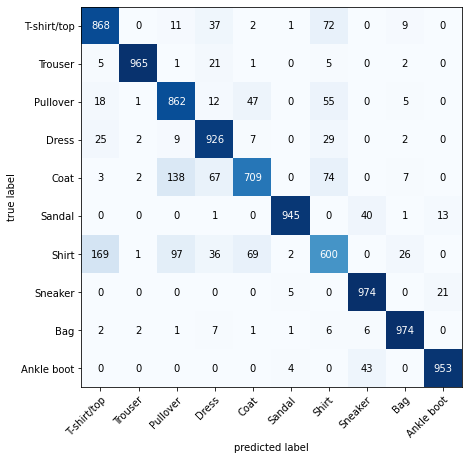

In [144]:
# 2. Setup a confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix using mlxtend
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7))

## 11. Saving and Loading the best model

In [145]:
from pathlib import Path

# Create directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving the model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving the model to: models/03_pytorch_computer_vision_model_2.pth


In [147]:
torch.manual_seed(42)

# Create a new instance
loaded_model_2 = FashionMNISTModelV2(input_shape=1, # Colour channels
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [148]:
torch.manual_seed(42)

# Evaluate the loaded model
print(model_2_results)
loaded_model_2_results = eval_model(model=loaded_model_2, 
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)
print(loaded_model_2_results)

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3443238437175751, 'model_acc': 87.77955271565496}


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3445955514907837, 'model_acc': 87.76956869009585}


In [149]:
# Check if model results are close together
torch.isclose(torch.tensor(model_2_results['model_loss']),
              torch.tensor(loaded_model_2_results['model_loss']),
              atol=1e-02)

tensor(True)

In [150]:
torch.isclose(torch.tensor(model_2_results['model_acc']),
              torch.tensor(loaded_model_2_results['model_acc']),
              atol=1e-02)

tensor(True)